##**CNN classification on raw time series data**

This notebook serves to classify the EEG data into tasks using the Shallow CNN. Three data augmentations are used:

*   Subsampling
*   Random Cropping
*   Sequential Cropping

The CNN is trained and evaluated on all of these different data augmentation methods. Data is sometimes split by person for analysis purposes. Due to RAM constraints, we restart the runtime after testing on a specific data augmentation method. To run a specific data augmentation method, only specific cells are required to run and will be specified.



Mount the google drive to create a valid path the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Load in BCI dataset

In [2]:
# load data
import os
import numpy as np
import random

try:  
  project_fname = '/content/drive/My Drive/c247/'
  os.chdir(project_fname)
  project_data_file = os.path.join(project_fname,'project_data/')
except FileNotFoundError: 
  project_fname = '/content/drive/My Drive/Colab Notebooks/c247'
  os.chdir(project_fname)
  project_data_file = os.path.join(project_fname,'project_data/')

from load_data import * 
from data_preprocessing import * 
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing

X_test, y_test, person_train_valid, X_train_valid, y_train_valid, person_test = load_data(dir_path = project_data_file)

# normalize the data
N_trials,N_eeg,N_bins,_ = X_train_valid.shape
#X_train_valid = np.reshape(preprocessing.scale(np.reshape(X_train_valid,(N_trials*N_eeg,N_bins)),axis=1),(N_trials,N_eeg,N_bins,1))
N_trials,N_eeg,N_bins,_ = X_test.shape
#X_test = np.reshape(preprocessing.scale(np.reshape(X_test,(N_trials*N_eeg,N_bins)),axis=1),(N_trials,N_eeg,N_bins,1))

num_test_samples = X_test.shape[0]
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000, 1)
Test data shape: (443, 22, 1000, 1)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


Subsample data (data augmentation cell; just for experimenting with subsampled data)

In [0]:
sample_every = 4
num_samples_per_trial = sample_every
X_train_valid_subsample, y_train_valid_subsample = shuffle_data(*subsample_data(X_train_valid, y_train_valid,sample_every=sample_every))
X_test_subsample, y_test_subsample = subsample_data(X_test, y_test,sample_every=sample_every)

Split data by subject (Another optional cell; just for experimenting subject by subject)

In [0]:
#split into subject
#no need to run this cell (free up ram)
X_train_valid_person = [X_train_valid[person_train_valid.flatten()==i] for i in range(9)]
y_train_valid_person = [y_train_valid[person_train_valid.flatten()==i] for i in range(9)]
person_train_valid_person = [person_train_valid[person_train_valid.flatten()==i] for i in range(9)]

X_test_person = [X_test[person_test.flatten()==i] for i in range(9)]
y_test_person = [y_test[person_test.flatten()==i] for i in range(9)]
person_test_person = [person_test[person_test.flatten()==i] for i in range(9)]

Crop the data with time windows specified by length and stride (another data augmentation cell; proven to greatly increase accuracy)

In [3]:
#crop samples to augment data

N,eeg,time,_ = X_train_valid.shape
sample_len=534
stride=50
num_crops = 10
num_samples_per_trial = int((1000-sample_len)/stride + 1)
num_samples = int(N*((1000-sample_len)/stride + 1))
X_train_valid_crop, y_train_valid_crop, person_train_valid_crop = crop_data_sequentially(X_train_valid,y_train_valid,person_train_valid,sample_len=sample_len,stride=stride)
X_test_crop, y_test_crop, person_test_crop = crop_data_sequentially(X_test,y_test,person_test,sample_len=sample_len,stride=stride)

del X_train_valid
del X_test
#shuffle the data
cv_idx=np.arange(X_train_valid_crop.shape[0])
np.random.shuffle(cv_idx)
X_train_valid_crop=X_train_valid_crop[cv_idx]
y_train_valid_crop=y_train_valid_crop[cv_idx]
person_train_valid_crop = person_train_valid_crop[cv_idx]

print('Training/Valid Cropped data shape: {}'.format(X_train_valid_crop.shape))
print('Training/Valid Cropped target shape: {}'.format(y_train_valid_crop.shape))
print('Training/Valid Cropped person shape: {}'.format(person_train_valid_crop.shape))
print('Test Cropped data shape: {}'.format(X_test_crop.shape))
print('Test Cropped target shape: {}'.format(y_test_crop.shape))
print('Test Cropped person shape: {}'.format(person_test_crop.shape))



Training/Valid Cropped data shape: (21826, 22, 534, 1)
Training/Valid Cropped target shape: (21826,)
Training/Valid Cropped person shape: (21826,)
Test Cropped data shape: (4571, 22, 534, 1)
Test Cropped target shape: (4571,)
Test Cropped person shape: (4571,)


Split cropped data into subject 

In [4]:
#split data in to subjects

X_train_valid_crop_person = [X_train_valid_crop[person_train_valid_crop==i] for i in range(9)]
y_train_valid_crop_person = [y_train_valid_crop[person_train_valid_crop==i] for i in range(9)]
person_train_valid_crop_person = [person_train_valid_crop[person_train_valid_crop==i] for i in range(9)]

X_test_crop_person =[X_test_crop[person_test_crop==i] for i in range(9)]
y_test_crop_person = [y_test_crop[person_test_crop==i] for i in range(9)]
person_test_crop_person = [person_test_crop[person_test_crop==i] for i in range(9)]

#free up ram
'''
del X_train_valid_crop
del X_test_crop
'''

print(X_train_valid_crop_person[0].shape)
print(y_train_valid_crop_person[0].shape)
print(person_train_valid_crop_person[0].shape)
print(X_test_crop_person[0].shape)
print(y_test_crop_person[0].shape)
print(person_test_crop_person[0].shape)

(3046, 22, 534, 1)
(3046,)
(3046,)
(641, 22, 534, 1)
(641,)
(641,)


Connect to Google TPUs

In [5]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

TensorFlow 2.x selected.
Tensorflow version 2.1.0
Running on TPU  ['10.8.43.170:8470']
INFO:tensorflow:Initializing the TPU system: 10.8.43.170:8470


INFO:tensorflow:Initializing the TPU system: 10.8.43.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [0]:
#import all needed modules
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Input,Dense,Conv2D,ReLU,ELU,\
  Activation,Flatten,AveragePooling2D,Softmax,BatchNormalization,MaxPooling2D,\
  Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,\
  ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
from datetime import datetime


Function used to specify Shallow CNN layers

In [0]:
def create_model():
  model = Sequential()
  model.add(Conv2D(filters=40,
                   kernel_size=(1,25),
                   data_format='channels_last',
                   kernel_regularizer=regularizers.l2(0.001),
                   input_shape=(22,534,1))) #(22,510,40)
  model.add(BatchNormalization(axis=-1))
  model.add(Dropout(rate=0.5))
  model.add(Conv2D(filters=40,
                  data_format='channels_last',
                  kernel_size=(22,1),
                  kernel_regularizer=regularizers.l2(0.001))) #(1,510,40)
  model.add(BatchNormalization(axis=-1))
  model.add(Activation(K.square,name='Square'))
  model.add(AveragePooling2D(pool_size=(1,75),strides=(1,15)))#(1,30,40)
  model.add(Activation(K.log,name='Log'))
  model.add(Flatten())
  model.add(Dense(100,
                  kernel_regularizer=regularizers.l2(0.001),
                  activation='relu'))
  model.add(Dense(num_classes,
                  activation='softmax'))
  return model

#initialize hyperparameters
rand_seed = int(datetime.strftime(datetime.now(),"%Y%m%d%H%M%S"))
batch_size=32
num_folds=5
num_classes = 4

Cell to train on data split by person. Trains one model a person

In [0]:
#create model


#lr = 9e-4

rates = [4e-3,5e-3,5e-3,2e-3,7e-3,9e-4,8e-3,7e-4,1e-3]
#Person Acc [0.72, 0.64, 0.78, 0.6, 0.48936170212765956, 0.46938775510204084, 0.66, 0.72, 0.7021276595744681]
#Person Acc [0.7, 0.54, 0.74, 0.62, 0.44680851063829785, 0.3673469387755102, 0.62, 0.62, 0.6808510638297872]
#Person Acc [0.78, 0.6, 0.74, 0.6, 0.6382978723404256, 0.4489795918367347, 0.74, 0.64, 0.6808510638297872]
#person acc [0.72, 0.56, 0.78, 0.6, 0.5319148936170213, 0.4489795918367347, 0.72, 0.72, 0.6808510638297872]
#Person Acc [0.74, 0.3, 0.76, 0.6, 0.46808510638297873, 0.46938775510204084, 0.7, 0.58, 0.6808510638297872]
#Person Acc [0.66, 0.6, 0.68, 0.62, 0.6170212765957447, 0.46938775510204084, 0.6, 0.78, 0.6595744680851063] rates = [5e-3,7e-3,5e-3,2e-3,7e-3,5e-4,8e-3,7e-4,1e-3]
#Person Acc [0.66, 0.56, 0.88, 0.58, 0.2978723404255319, 0.5306122448979592, 0.84, 0.78, 0.574468085106383] rates = [5e-3,7e-3,5e-3,2e-3,7e-3,6e-4,8e-3,7e-4,1e-3]
#Person Acc [0.5, 0.28, 0.86, 0.4, 0.723404255319149, 0.4489795918367347, 0.58, 0.78, 0.7021276595744681]   rates = [5e-3,7e-3,5e-3,2e-3,7e-3,6e-4,8e-3,7e-4,1e-3] changed stride to 25
#Person Acc [0.74, 0.54, 0.76, 0.64, 0.6170212765957447, 0.42857142857142855, 0.82, 0.78, 0.6808510638297872] rates = [4e-3,8e-3,5e-3,2e-3,7e-3,7e-4,8e-3,7e-4,1e-3]
# Person Acc [0.8, 0.4, 0.74, 0.68, 0.6808510638297872, 0.46938775510204084, 0.62, 0.64, 0.6808510638297872] rates = [4e-3,8e-3,5e-3,2e-3,7e-3,7e-4,8e-3,7e-4,1e-3] initialzation to he normal
#Person Acc [0.68, 0.4, 0.76, 0.66, 0.6595744680851063, 0.4489795918367347, 0.78, 0.78, 0.6382978723404256] rates = [4e-3,9e-3,5e-3,2e-3,7e-3,8e-4,8e-3,7e-4,1e-3]
#[0.78,0.6,0.88,0.68,0.72,0.53,0.84,0.78,0.70]
#current avg of best test acc: 0.72
try:
  del model
  K.clear_session()
except:
  pass
print('BATCH SIZE: {}'.format(batch_size))
models = []
person_accuracies = []
avg_test_acc = np.zeros(9)
lr_plateau = ReduceLROnPlateau(patience=4)
early_stopper = EarlyStopping(patience=10)

for person in range(9):

  print('PERSON: {}'.format(person))
  print('LEARNING RATE: {}'.format(rates[person]))

  models.append(create_model())
  optimizer = Adam(lr=rates[person])
  
  
  
  #optimizer = SGD(lr=lr, momentum=0.9,decay=1e-6)
  models[person].compile(loss=categorical_crossentropy,optimizer=optimizer,metrics=['accuracy'])
  #train model
  
  history = models[person].fit(x=X_train_valid_crop_person[person], y=to_categorical(y_train_valid_crop_person[person]), 
                      batch_size=batch_size, epochs=30, 
                      validation_split=1/num_folds,
                      callbacks=[early_stopper, lr_plateau])

  # Plot training & validation accuracy values
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  correct = 0
  N,_,_,_ = X_test_crop_person[person].shape
  scores = np.zeros(num_classes)
  test_data = X_test_crop_person[person]
  test_label = y_test_crop_person[person]
  for i in range(int(N/num_samples_per_trial)):
    strt_idx = i*num_samples_per_trial
    test_batch = test_data[strt_idx:strt_idx+num_samples_per_trial]
    scores = np.mean(models[person].predict_on_batch(x=test_batch),axis=0)
    pred = np.argmax(scores)
    if pred == test_label[strt_idx]:
          correct += 1
  test_acc = correct/(N/num_samples_per_trial)
  print('Test accuracy: {}'.format(test_acc))
  person_accuracies.append(test_acc)

print('Person Acc {}'.format(person_accuracies))
print('Test Avg Mean Acc :{}'.format(np.mean(person_accuracies)))

Tests each model on the corresponding test set only for specific subject

In [0]:
#one model per person
person_accuracies = []
avg_test_acc = np.zeros(9)

for person in range(9):
  correct = 0
  N,_,_,_ = X_test_crop_person[person].shape
  scores = np.zeros(num_classes)
  test_data = X_test_crop_person[person]
  test_label = y_test_crop_person[person]

  for i in range(int(N/num_samples_per_trial)):
    strt_idx = i*num_samples_per_trial
    test_batch = test_data[strt_idx:strt_idx+num_samples_per_trial]
    scores = np.mean(model.predict_on_batch(x=test_batch),axis=0)
    pred = np.argmax(scores)
    if pred == test_label[strt_idx]:
          correct += 1
  test_acc = correct/(N/num_samples_per_trial)
  print('Test accuracy: {}'.format(test_acc))
  person_accuracies.append(test_acc)

print('Person Acc {}'.format(person_accuracies))
print('Test Avg Mean Acc :{}'.format(np.mean(person_accuracies)))

Averages all model confidence outputs for entire test set. Does not perform well.

In [0]:
#model ensembling: train multiple models and average their predictions on entire test set
#test_avg_ensembling  = 0.42 when each model trained to one person
#try training multiple modesl on entire dataset and then ensembling together
avg_test_ensemble = []
correct=0
test_data=X_test_crop
test_label=y_test_crop

for i in range(3):
  strt_idx = i*num_samples_per_trial
  scores = np.zeros((num_classes))
  test_batch = test_data[strt_idx:strt_idx+num_samples_per_trial]
  for person in range(9):
    model_ensemble = models[person]
    score=np.zeros(4)
    score += np.mean(model_ensemble.predict_on_batch(x=test_batch),axis=0)
    scores+=score
    print(score)
  pred = np.argmax(scores)
  if pred == test_label[strt_idx]:
    correct += 1

print('Test_acc_avg_ensemble: {}'.format(correct/(N/num_samples_per_trial)))

Cell to train on cropped data (not split by subject)

In [0]:
#reset model variable to train another one
try:
  del model
  K.clear_session()
except:
  pass
  
model = create_model()
optimizer = Adam(lr=2e-3)

model.compile(loss=categorical_crossentropy,optimizer=optimizer,metrics=['accuracy'])
plot_model(model,'cnn_baseline.png',show_shapes=True)

Trains Shallow CNN on entire training cropped set. Utilizes ReduceLRonPlateau and EarlyStopping callbacks to improve performance.

In [0]:
#introduced l1 regularization to spatial convolution lr=1e-3
#Test acc per person: [0.62       0.34       0.78       0.46       0.46808511 0.46938776 0.74       0.8        0.74468085] Avg test acc: 0.6024615236165389
#raise lr to 2e-3 set ReduceLROnPlateau patience to 2
#Test acc per person: [0.58       0.46       0.82       0.58       0.46808511 0.3877551 0.66       0.72       0.63829787] Avg test acc: 0.59045978675158
#removed l1 regularization
#Test acc per person: [0.6        0.48       0.82       0.6        0.40425532 0.53061224 0.76       0.84       0.65957447] Avg test acc: 0.6327157813480002
#Adam lr=9e-4 l2 reg=0.01
#Test acc per person: [0.64       0.42       0.72       0.54       0.4893617  0.46938776 0.64       0.7        0.74468085] Avg test acc: 0.5959367009215034
#changed sample len to 534 to perfectly mimic paper changed lr plateau patience to 3
#Test acc per person: [0.71762871 0.44       0.88       0.54       0.40425532 0.51020408 0.56       0.68       0.65957447]Avg test acc: 0.599073619334989
#added relu layer in between conv layers Test acc per person: [0.65522621 0.34       0.66       0.52       0.5106383  0.36734694 0.52       0.7        0.57446809] Avg test acc: 0.5386310589780661
#removed relu added dense layer Test acc per person: [0.74882995 0.32       0.7        0.54       0.42553191 0.42857143 0.56       0.74       0.72340426]Avg test acc: 0.5762597279980359
#used sgd at lr=1e-2 Test acc per person: [0.73322933 0.24       0.76       0.48       0.4893617  0.40816327 0.68       0.66       0.68085106] Avg test acc: 0.5701783733818595
#switched back to adam removed dense layer and set lr=3e-3 Test acc per person: [0.74882995 0.38       0.72       0.52       0.38297872 0.44897959 0.56       0.62       0.70212766] Avg test acc: 0.5647684364459541
#lecun_normal initialization Test acc per person: [0.74882995 0.38       0.72       0.52       0.38297872 0.44897959 0.56       0.62       0.70212766] Avg test acc: 0.5647684364459541
#went for 80 epochs Test acc per person: [0.81123245 0.46       0.8        0.62       0.4893617  0.51020408 0.7        0.78       0.72340426] Avg test acc: 0.6549113875974927
#changed l2 reg to 0.001 added dense layer Test acc per person: [0.73322933 0.68       0.84       0.58       0.4893617  0.53061224 0.74       0.78       0.76595745] Avg test acc: 0.6821289692230329
#changed relu in dense layer to elu Test acc per person: [0.71762871 0.46       0.9        0.5        0.36170213 0.44897959 0.76       0.84       0.78723404] Avg test acc: 0.6417271630219674
#changed back to relu and added batch norm layer after dense Test acc per person: [0.74882995 0.52       0.82       0.62       0.53191489 0.53061224 0.82       0.74       0.76595745] Avg test acc: 0.6774793931690688
#removed added batch norm added temporal conv layer (took too long to train so colab just stopped)
#changed batch size to 64 Test acc per person: [0.71762871 0.52       0.78       0.58       0.5106383  0.44897959 0.74       0.8        0.80851064] Avg test acc: 0.6561952481283504
#change initialization to lecun normal Test acc per person: [0.74882995 0.5        0.82       0.56       0.53191489 0.48979592  0.76       0.86       0.80851064] Avg test acc: 0.6754501559422632
#added relu after first conv layer Test acc per person: [0.68642746 0.44       0.78       0.68       0.4893617  0.48979592 0.64       0.72       0.68085106] Avg test acc: 0.6229373490470087 BUT 72% VAL ACCURACY
#train on uncropped data Test acc per person: [0.6        0.42       0.74       0.62       0.72340426 0.44897959 0.6        0.64       0.59574468] Avg test acc: 0.5986809475563274
#removed relu at first dense layer Test acc per person: [0.60842434 0.52       0.78       0.54       0.5106383  0.51020408 0.54       0.68       0.63829787] Avg test acc: 0.5919516209798776 | 77% VAL ACCURACY
#changed num filters in first conv layer to 45 and reg to 0.001Test acc per person: [0.60842434 0.44       0.7        0.54       0.46808511 0.40816327 0.68       0.62       0.59574468] Avg test acc: 0.5622685988348493
#removed relu at first conv layer and set reg to 0.001 Test acc per person: [0.703125   0.52       0.78       0.74       0.46808511 0.51020408 0.66       0.76       0.72340426] Avg test acc: 0.6516464937038645
#changed num filters to 35 Test acc per person: [0.66       0.44       0.72       0.58       0.53191489 0.40816327 0.78       0.7        0.63829787] Avg test acc: 0.6064862256959521
#change num filters back to 40 and made hidden layer 120 instead of 100 Test acc per person: [0.62       0.6        0.76       0.64       0.53191489 0.48979592 0.64       0.72       0.72340426] Avg test acc: 0.6361238963670576

#train model
batch_size=128
lr_plateau = ReduceLROnPlateau(patience=4)
early_stopper = EarlyStopping(patience=20)

model_check_fname = os.path.join(project_fname,'model_checkpoints/','ckpt-CNN')
time_rn = (datetime.strftime(datetime.now(),"%H_%M_%S_%d_%m_%Y"))
model_filename = os.path.join(model_check_fname,'model_{}.h5'.format(time_rn))

try:
  history = model.fit(x=X_train_valid_crop, y=to_categorical(y_train_valid_crop), 
                      batch_size=batch_size, epochs=200, 
                      validation_split=1/num_folds,
                      callbacks=[lr_plateau,early_stopper])
except KeyboardInterrupt:
  print('Keyboard Interrupted!')
except Exception as e:
  print('Unknown error: {}'.format(e))
finally:
  print('Saving model to {}'.format(model_filename))
  model.save(model_filename)



# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


Tests model on entire test cropped set. Averages model predictions on all the crops for one trial.

In [9]:
#test on cropped data
X_test_crop_person = [X_test_crop[person_test_crop.flatten()==i] for i in range(9)]
y_test_crop_person = [y_test_crop[person_test_crop.flatten()==i] for i in range(9)]
model_check_fname = os.path.join(project_fname,'model_checkpoints/','ckpt-CNN')
model = load_model(os.path.join(model_check_fname,'model_18_00_20_10_03_2020_68%.h5'),
                   custom_objects={'square':K.square,'log':K.log})

person_acc = np.zeros(9)
preds = np.empty((0))
labels = np.empty((0))

for person in range(9):
  correct = 0
  N,_,_,_ = X_test_crop_person[person].shape
  scores = np.zeros(num_classes)
  test_data = X_test_crop_person[person]
  test_label = y_test_crop_person[person]
  for i in range(int(N/num_samples_per_trial)):
    strt_idx = i*num_samples_per_trial
    test_batch = test_data[strt_idx:strt_idx+num_samples_per_trial]
    raw_scores = model.predict_on_batch(x=test_batch)
    scores = np.mean(raw_scores,axis=0)
    pred = np.argmax(scores)

    assert all(y == test_label[strt_idx] for y in test_label[strt_idx:strt_idx+num_samples_per_trial])
    preds = np.append(preds,pred)
    labels = np.append(labels,test_label[strt_idx])
    if pred == test_label[strt_idx]:
          correct += 1
  test_acc = correct/(i+1)
  person_acc[person]=test_acc
print('Test acc per person: {}'.format(person_acc))
print('Avg test acc: {}'.format(np.mean(person_acc)))

Test acc per person: [0.734375   0.68       0.84       0.58       0.4893617  0.53061224
 0.74       0.78       0.76595745]
Avg test acc: 0.6822562659815699


Create and display the confusion matrix for the model on sequentially cropped data.

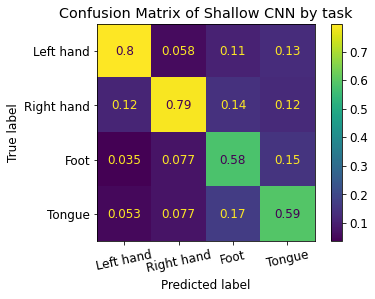

In [13]:
display_labels = ['Left hand', 'Right hand','Foot','Tongue']
confusion = confusion_matrix(y_true=labels, y_pred=preds, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=confusion,
                              display_labels=display_labels)
disp.plot()
disp.ax_.set_xticklabels(display_labels, rotation=12)
plt.title('Confusion Matrix of Shallow CNN by task')

plt.savefig('CNN_confusionmatrix.png')
plt.show()

Test on raw data (uncropped and not subsampled)

In [0]:
#test on uncropped data
person_acc = np.zeros(9)

for person in range(9):
  correct = 0
  N,_,_,_ = X_test_person[person].shape
  scores = np.zeros(num_classes)
  test_data = X_test_person[person]
  test_label = y_test_person[person]
  scores = model.predict_on_batch(x=test_data)
  pred = np.argmax(scores,axis=1)
  correct = np.sum(pred == test_label)
  test_acc = correct/(N)
  person_acc[person]=test_acc
print('Test acc per person: {}'.format(person_acc))
print('Avg test acc: {}'.format(np.mean(person_acc)))

In [0]:
try:
  del model
  K.clear_session()
except:
  pass
  
model = create_model()
optimizer = Adam(lr=9e-4)
#optimizer = SGD(lr=1e-3, momentum=0.9,decay=1e-6)
model.compile(loss=categorical_crossentropy,optimizer=optimizer,metrics=['accuracy'])

Trains on subsampled data (Overfits the subsampled data and does not generalize well to new data since training and validation data are closely correlated)

In [0]:
#train on subsampled data
batch_size=32
lr_plateau = ReduceLROnPlateau(patience=3)
early_stopper = EarlyStopping(patience=8)
history = model.fit(x=X_train_valid_subsample, y=to_categorical(y_train_valid_subsample), 
                    batch_size=batch_size, epochs=10, 
                    validation_split=1/num_folds,
                    callbacks=[early_stopper,lr_plateau])

try:
  model_check_fname = os.path.join(project_fname, 'model_checkpoints/')
  time_rn = (datetime.strftime(datetime.now(),"%H_%M_%S_%d_%m_%Y"))
  model_filename = os.path.join(model_check_fname,'model{}.h5'.format(time_rn))
  print('Saving model weights to {}'.format(model_filename))
  model.save_weights(model_check_fname)
except Exception as e:
  print(e)


# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Test on subsampled data

In [0]:
#subsampling gives good training and validation loss but not good generalization
#to test data at all since the training and validation data are closely correlated
correct = 0
print('num_samples_per_trial: {}'.format(num_samples_per_trial))
N,_,_,_ = X_test_subsample.shape
scores = np.zeros(num_classes)
test_data = X_test_subsample
test_label = y_test_subsample
for i in range(int(N/num_samples_per_trial)):
  strt_idx = i*num_samples_per_trial
  test_batch = test_data[strt_idx:strt_idx+num_samples_per_trial]
  scores = np.mean(model.predict_on_batch(x=test_batch),axis=0)
  pred = np.argmax(scores)
  if pred == test_label[strt_idx]:
        correct += 1
test_acc = correct/(N/num_samples_per_trial)
print('Test acc: {}'.format(test_acc))

num_samples_per_trial: 4
Test acc: 0.4198645598194131
